In [ ]:
# build a multilingual transformer which enables zero shot cross-lingual transfer
# suitable for 'code-switching' where a speaker may alternate between two or more languages
# fine tune a XLM-RoBERTa model to perform NER across several languages
# the dataset is a subset of Cross-lingual Transfer Evalaution of Multilingual Encoders (XTREME) benchmark
# called WikiANN or PAN-X. It contains Wikipedia pages of many languages including four of the most
# common spoken in Switerland (German 62.9%, FRench 22.9%, Italian 8.4% and English 5.9%)
# each artical is annotated with LOC (location), PER(person), and ORG (organisation) tags in the IOB2 format
!pip install datasets

In [ ]:
# load one of the PAN-X subsets
from datasets import get_dataset_config_names
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for xtreme contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xtreme
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


XTREME has 183 configurations


In [ ]:
# each PAN-X subset has a two-letter suffix which is the ISO 639-l language code
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [ ]:
# for a realistic Swiss corpus the German (de), French (fr), Italian (it) and English (en) will be sampled.
# the language dataset will be imbalanced but will be addressed later

from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# return a DatasetDict if a key doen't match
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # load monolingual corpus
  ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed=0)
        .select(range(int(frac * ds[split].num_rows))))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for xtreme contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xtreme
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
# inspect one of the German examples in corpus.
# There are way more German examples, than all the other languages combined
# however it can be used to perform zero-shot cross-lingual transfer to
# French, Italian and English

element = panx_ch["de"]["train"][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [ ]:
# the ner_tags are mapped to numerically
# create a sperate column with familiar NER tags for human readability

for key, value in panx_ch["de"]["train"].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [ ]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [ ]:
# create a new column in the training dataset using the int2str() method with class names for each tag
# the map () method returns a dict with the key corresponding to the new column name and the value as a list of class names
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [ ]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
             ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
# calculate the frequencies of each entity across each split
# to check for major imbalances
from collections import Counter
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")


,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [ ]:
# tokenizer for XLM-RoBERTa model, uses SentencePiece tokenizer and is trained on the raw text of 100 languages
# vocab size is 250,000 tokens and tokenises the raw text directly

from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)




In [ ]:
# see the difference between the tokenizers
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()
print(bert_tokenizer(text).tokens())
print(xlmr_tokenizer(text).tokens())

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [ ]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

In [ ]:
# create custom model for token classification
# can import XLMRobertaForTokenClassification class from hugging face for this task also
# config_class uses the standard XLM-RoBERTA defaults parameters
# super() method initialises the config setup and loads the pretrained weights
# Roberta model used as the base model, and extended with a custom classification head
# consisting of a dropout and standard feed-forwrd layer


import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
'''
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    #super().__init(config)
    self.num_labels = config.num_labels
    # load model body
    self.roberta = RobertaModel(config, add_pooling_layer=False)
    # set up classification head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    # load and initialize weights
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None,
              token_type_ids=None, labels=None, **kwargs):
    # use model body to get encoder representations
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                           token_type_ids=token_type_ids, **kwargs)
    # apply classifier to encoder representations
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    # calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    # return model output object
    return TokenClassifierOutput(loss=loss, logits=logits,
                                 hidden_states=outputs.hidden_states,
                                 attentions=outputs.attentions)
 '''

'\nclass XLMRobertaForTokenClassification(RobertaPreTrainedModel):\n  config_class = XLMRobertaConfig\n\n  def __init__(self, config):\n    #super().__init(config)\n    self.num_labels = config.num_labels\n    # load model body\n    self.roberta = RobertaModel(config, add_pooling_layer=False)\n    # set up classification head\n    self.dropout = nn.Dropout(config.hidden_dropout_prob)\n    self.classifier = nn.Linear(config.hidden_size, config.num_labels)\n    # load and initialize weights\n    self.init_weights()\n\n  def forward(self, input_ids=None, attention_mask=None,\n              token_type_ids=None, labels=None, **kwargs):\n    # use model body to get encoder representations\n    outputs = self.roberta(input_ids, attention_mask=attention_mask,\n                           token_type_ids=token_type_ids, **kwargs)\n    # apply classifier to encoder representations\n    sequence_output = self.dropout(outputs[0])\n    logits = self.classifier(sequence_output)\n    # calculate losses

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import XLMRobertaForTokenClassification

In [ ]:
# load the custom model
# provide tags to the model to label each entity and the mapping of each tag to an ID and vice versa

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
# pass these mappings to AutoConfig
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [ ]:
import torch
# load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# check the model and tokenizer have initialised correctly
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
# pass the inputs to the model and extract the predictions by taking the argmax
# to get the most likely class per token
# logits are [batch_size, num_tokens, num_tags]

outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1),
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")


Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [ ]:
# enumerate over the sequence to see what the the pretrained model predicts

def tag_text(text, tags, model, tokenizer):
  # get tokens with special characters
  tokens = tokenizer(text).tokens()
  # encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
  # get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # take argmax to get most likely class per token
  predictions = torch.argmax(outputs, dim=2)
  # convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])


In [ ]:
# now the tokenizer and mode can encode a singel example
# next tokenise the entire dataset and pass to the XLM-RoBERTa model for fine-tuning

words, labels = de_example["tokens"], de_example["ner_tags"]
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:
# To follow B-LOC convention and mask subwords using words_ids() from tokenized_input
# map each subword to the corresponding index in the words sequence

word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:
# set special tokens [e.g., <s> and <\s> etc] to ID -100. In PyTorch the Cross-entropy loss class
# has an attribute ignore_index when set to -100, and therefore ignored during training

previous_word_idx = None
label_ids = []

for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:
# scale above to handle the entire dataset

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                    is_split_into_words=True)

  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

In [ ]:
# function to iterate over each split

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,
                    remove_columns=['langs', 'ner_tags', 'tokens'])

panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
!pip install seqeval

In [ ]:
# performance metrics
# similiar to evaluating a text classification model
# commonly use precision, recall and f1
# however all words of an entity must be predicted correctly for the prediction to be counted as correct

from seqeval.metrics import classification_report



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      #ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

In [ ]:
!pip install transformers[torch]
#!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
# fine-tuning XLM-Roberta
# firstly, fine-tune the base model on the German subset of PAN-X
# secondly, evaluate its zero cross-lingual performance on French, Italian and English
# will need to restart the session for this cell to work

from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level='error', num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

In [ ]:
# connect with hugginface hub and push trained to model to hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# compute predictions
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
# pads the data sequences to the largest in length in the dataset
# padded with -100
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
# this fx avoids initializing a new model for every Trainer by creating a model_init() method
# this method loads an untrained model
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [ ]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.258500,0.151037,0.823576
2,0.124600,0.142676,0.851093
3,0.080000,0.136972,0.864374


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

events.out.tfevents.1705609649.bf04fdf324c9.7622.0:   0%|          | 0.00/6.35k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/2O24dpower2024/xlm-roberta-base-finetuned-panx-de/commit/efc7d49af7e051fc52c6787317830b734fb91681', commit_message='Training completed!', commit_description='', oid='efc7d49af7e051fc52c6787317830b734fb91681', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# test some text on the model
text_de = "Dave Power ist ein Infomatiker bei ASSERT in Cork, Irland."
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Tokens,<s>,▁Dave,▁Power,▁ist,▁ein,▁Info,matik,er,▁bei,▁,ASS,ERT,▁in,▁Cor,k,",",▁Irland,.,</s>
Tags,O,B-PER,I-PER,O,O,O,O,O,O,B-ORG,B-ORG,I-ORG,O,B-LOC,I-LOC,O,B-LOC,O,O


In [ ]:
# error analysis
# check to see if accidentally masked too many tokens or masked too many labels, which would artificially drop the loss
# comput_metrics() fx may have a bug that overestimates performance
# might include the zero class or 0 entity in NER as a normal class, which will heavily skew accuracy and F1
# if the model performs worse than expected, checking errors can identify bugs not noticed looking at the code
# even if no bugs and good performance, it is good practice to understance the models strengths and weaknesses
# good practice for deploying to prod

# check the examples with the highest validation loss

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    # pass data through model
    output = trainer.model(input_ids, attention_mask)
    # logit.size: [batch_size, sequence_length, classes]
    # predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  # calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1, 7),
                       labels.view(-1), reduction='none')
  # unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss":loss, "predicted_label": predicted_label}

In [ ]:
# apply forward_pass_with_label fx to whole validation set using map()
# and load to DataFrame for further analysis

valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.027758716, 0.0, 0.015716143, 0.0137669...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.03,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.79,B-ORG,▁Luz
1,10,1,I-ORG,0.73,I-ORG,▁a


In [ ]:
# group the data, and aggregate the losses for each token with count, mean and sum

(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

# the whitespace token has the highest total sum, because it is the most common.
# however, the mean loss is the lowest meaning the model finds it easy to classify.
# words like 'in', 'von', 'der' and 'und' occur frequently and sometimes together
# with named entities so it's easy for the model to mix them up

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.03,0.1,0.13,0.15,0.63,0.08,0.28,0.26,0.02,0.44
sum,194.72,143.71,132.88,124.11,103.25,89.32,69.96,64.9,57.44,55.01


In [ ]:
# look at the losses for each class

(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-LOC,B-ORG,B-PER,I-LOC,I-ORG,I-PER,O
count,3172,2683,2893,1462,3820,4139,43648
mean,0.3,0.63,0.26,0.57,0.51,0.2,0.03
sum,959.69,1703.65,741.18,838.88,1958.19,840.63,1362.77


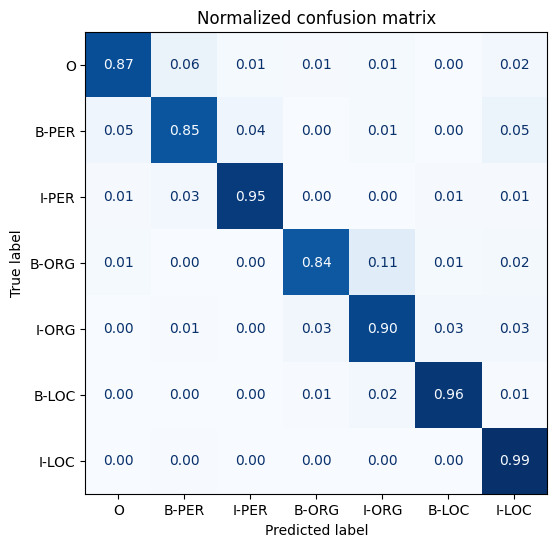

In [ ]:
# investiagte further with a confusion matrix
# the I-ORG and B-ORG are sometimes getting misclassified

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [ ]:
# now that the errors are checked at token level
# check the errors at sequence level

def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                           "preds": preds, "losses": losses}).T
    yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)

# something wrong with the labels as the united nations and central africian republic are labeled as PER and juli as an ORG
# the annotations in PAN_X were automated, known as 'silver standard'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,B-ORG,O,O,B-ORG,O,O,O,O,O,O,O
losses,0.00,0.00,2.67,0.00,0.00,0.00,10.89,9.32,7.95,6.07,7.15,0.00,7.27,7.83,0.00,7.73,7.68,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.37,0.00,0.00,6.74,8.39,8.49,5.40,0.00,8.70,8.81,7.48,6.49,4.48,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.25,5.85,6.00,0.00,6.06,0.00,5.85,0.00,5.25,5.86,6.29,6.25,5.51,5.34,0.00


In [ ]:
# it seems the automated annotation tagged paraenthesis also as ORG
# this error analysis had identified weaknesses and potential inplications for downstream performance

df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.03,0.00,0.02,0.01,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


In [ ]:
# cross-lingual transfer

# evaluate the ability to transfer to other languages using the predict() method of Trainer

def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
# determine performance

f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.869


In [ ]:
# test French sample

text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [ ]:
# test German model on the whole French test set
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds['test'])

f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

# 0.7 is good considering it has not seen a French word yet
# German and French are not similiar

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.702


In [ ]:
# test German model on the whole Italian test set
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")


Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.686


In [ ]:
# test German model on the whole English test set
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

# it performs worst on English which is suprising

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.594


In [ ]:
# fine-tune XLM-RoBERTa on the French corpus on training sets on increasing size.
# This way by tracking performance it can be determined at which point zero-point cross-lingual tranfer is superior

def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds) // batch_size

  trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message='Training completed!')

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]}
    )

In [ ]:
# encode the French corpus into input IDs, attentions masks, and label IDs, like the German corpus
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [ ]:
# check fx works on sample of 250 examples [ gives very poor performance]
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)

metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.813200,1.355362,0.060841
2,1.326700,1.184780,0.174783
3,1.139900,1.118581,0.165209


In [ ]:
# increase the training set sizes and check performance

import pandas as pd

metrics_df = pd.DataFrame()

for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True
    )


Epoch,Training Loss,Validation Loss,F1
1,1.502300,1.002398,0.231475
2,0.838700,0.672523,0.555197
3,0.566000,0.550977,0.690791


<ipython-input-60-2c0b13eef39b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


Epoch,Training Loss,Validation Loss,F1
1,1.196400,0.703731,0.574808
2,0.522800,0.409504,0.723902
3,0.319900,0.388889,0.755102


Epoch,Training Loss,Validation Loss,F1
1,0.809900,0.408187,0.742763
2,0.313900,0.340250,0.796451
3,0.225100,0.329678,0.811144


Epoch,Training Loss,Validation Loss,F1
1,0.608300,0.329702,0.787869
2,0.265000,0.303068,0.818258
3,0.177700,0.278035,0.837820


In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tunes on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
# concatenate datasets

from datasets import concatenate_datasets

def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus

# conacatenate German and French datasets
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])



In [ ]:
# train model

training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.288700,0.187916,0.813116
2,0.148400,0.160395,0.842302
3,0.098100,0.164818,0.858287


training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/2O24dpower2024/xlm-roberta-base-finetuned-panx-de-fr/commit/880b33e1281c54210e844c495aa73ba4a995113d', commit_message='Training completed!', commit_description='', oid='880b33e1281c54210e844c495aa73ba4a995113d', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
corpora= [panx_de_encoded]

# exclude German from iteration
for lang in langs[1:]:
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  # fine-tune on monolingual corpus
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  # collect F1-scores in common dict
  f1_scores[lang][lang] = metrics["f1_score"][0]
  # add monolingual corpus to list of corpora to concatenate
  corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.577900,0.359656,0.778261
2,0.271300,0.278673,0.824218
3,0.180600,0.274717,0.845218


training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.809600,0.353976,0.738277
2,0.299000,0.267712,0.789132
3,0.193700,0.256368,0.825358


training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,1.111500,0.630175,0.488459
2,0.510400,0.417510,0.652678
3,0.350000,0.404442,0.672231


training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

In [ ]:
# following fine-tuning on each language corpus, concatenate all the splits into
# a multilingual corpus of all four languages
corpora_encoded = concatenate_splits(corpora)

In [ ]:

# train the model
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.302600,0.185123,0.818179
2,0.157500,0.171220,0.841296
3,0.103100,0.174206,0.854137


training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/2O24dpower2024/xlm-roberta-base-finetuned-panx-all/commit/584f7acca14e625e5568f1ddc1dfe002ffd7f484', commit_message='Training completed!', commit_description='', oid='584f7acca14e625e5568f1ddc1dfe002ffd7f484', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# generate predictions from the trainer on each language test set

for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

  scores_data = {"de": f1_scores["de"],
                 "each": {lang: f1_scores[lang][lang] for lang in langs},
                 "all": f1_scores["all"]}
  f1_scores_df = pd.DataFrame(scores_data).T.round(4)
  f1_scores_df.rename_axis(index="Fine-tine on", columns="Evaluation on",
                           inplace=True)

f1_scores_df

Evaluation on,de,fr,it,en
Fine-tine on,,,,
de,0.8692,0.7024,0.6855,0.5944
each,0.8692,0.8528,0.8076,0.6971
all,0.8708,0.8591,0.8674,0.7726
